Test performance:
 RMSE: 3.3140
 MAE : 2.8631
 MAPE (%): 3.47


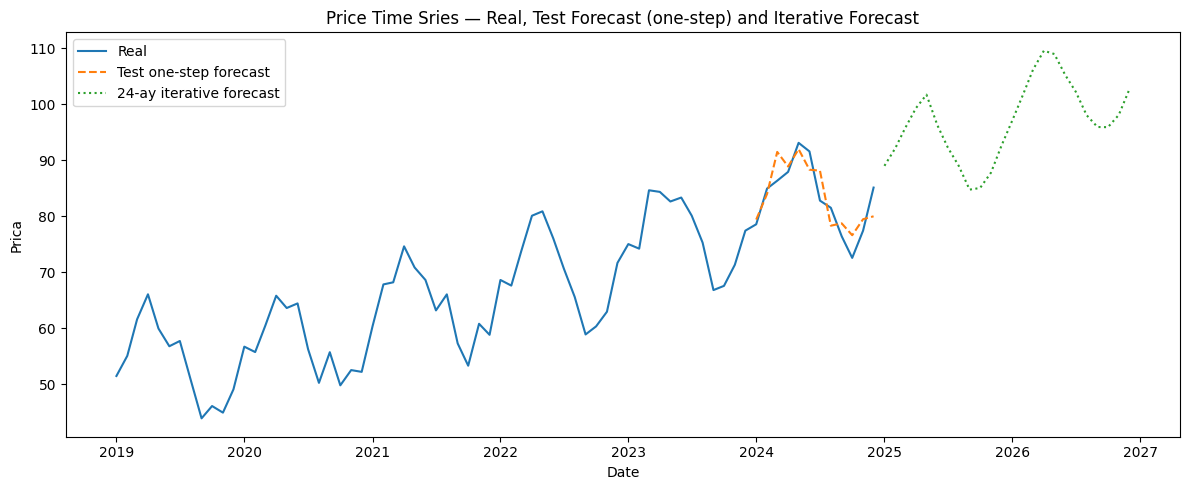

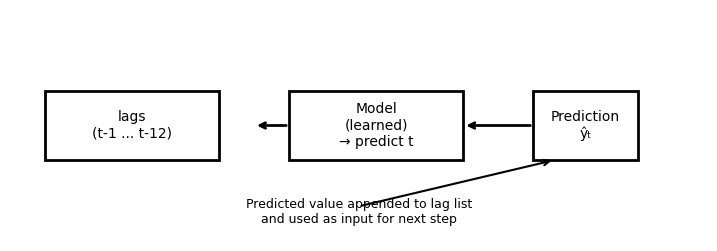


Saved Files (outputs folder):
total 184
drwxr-xr-x   6 nurdanaydogdu  staff    192 14 Kas 12:58 .
drwxr-x---+ 78 nurdanaydogdu  staff   2496 14 Kas 22:59 ..
-rw-r--r--   1 nurdanaydogdu  staff    708 16 Kas 18:13 24mo_forecast.csv
-rw-r--r--   1 nurdanaydogdu  staff  16631 16 Kas 18:13 iterative_schematic.png
-rw-r--r--   1 nurdanaydogdu  staff  61689 16 Kas 18:13 price_forecast_plot.png
-rw-r--r--   1 nurdanaydogdu  staff    585 16 Kas 18:13 test_results.csv


In [2]:
# Full runnable example for Google Colab:
# - Generates synthetic monthly price series
# - Generates lag_1..lag_12 features
# - Trains for the first 48 months, tests for the next 12 months (using a total of 72 months of synthetic data)
# - Trains an autoregressive (one-step-ahead) model with LinearRegression
# - Prints test performance (RMSE, MAE, MAPE)
# - Generates 24-month iterative forecast starting from the last 12 months
# - Saves images to ./outputs and displays them in Colab
# - Includes a google.colab.files.download example to make them downloadable

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime

# ---------- Settings ----------
np.random.seed(42)
periods = 72         # 72 months of synthetic data (6 years) -> 60 rows will remain after droplag
max_lag = 12
train_rows_after_dropna = 48  # How many lines will we use as trains after dropna (48 trains, 12 tests)
forecast_horizon = 24         # Number of months to be predicted iteratively
output_dir = "./outputs"      # Colab-compatible output directory
os.makedirs(output_dir, exist_ok=True)

# ---------- 1) Synthetic data generation ----------
dates = pd.date_range(start="2019-01-01", periods=periods, freq="MS")  # monthly, month start
trend = 0.5 * np.arange(periods)                                      # basic linear trend
seasonal = 10 * np.sin(2 * np.pi * np.arange(periods) / 12)           # annual seasonal component
noise = np.random.normal(scale=3.0, size=periods)                     # random noise
base = 50
prices = base + trend + seasonal + noise
series = pd.Series(prices, index=dates, name="price")

# ---------- 2) Lag Feautures (1..12) ----------
df = pd.DataFrame(series)
for lag in range(1, max_lag + 1):
    df[f"lag_{lag}"] = df["price"].shift(lag)
df_clean = df.dropna().copy()  # first 12 rows disappear -> remaining = periods - max_lag

# ---------- 3) Train / Test split ----------
# total rows after dropna = periods - max_lag
total_after = df_clean.shape[0]
if train_rows_after_dropna + 12 > total_after:
    raise ValueError("train_rows_after_dropna + 12 (test) exceed available rows after dropna. Adjust periods or train size.")

train = df_clean.iloc[:train_rows_after_dropna]
test = df_clean.iloc[train_rows_after_dropna: train_rows_after_dropna + 12]

X_train = train[[f"lag_{i}" for i in range(1, max_lag + 1)]].values
y_train = train["price"].values
X_test = test[[f"lag_{i}" for i in range(1, max_lag + 1)]].values
y_test = test["price"].values
test_index = test.index

# ---------- 4) Model training (Linear Regression - Autoregresif) ----------
model = LinearRegression()
model.fit(X_train, y_train)

# ---------- 5) One-step-ahead test predictions (with real lag values) ----------
y_pred_test = model.predict(X_test)

# ---------- 6) Performance Metrics ----------
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_test = math.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mape(y_test, y_pred_test)

print("Test performance:")
print(f" RMSE: {rmse_test:.4f}")
print(f" MAE : {mae_test:.4f}")
print(f" MAPE (%): {mape_test:.2f}")

# ---------- 7) Iterative 24 monthly forecast ----------
# Take the last observed max_lag value as seed (last observations of the original series)
last_observed = df["price"].iloc[-max_lag:].values.tolist()  # last 12 observations
iter_preds = []
iter_dates = pd.date_range(start=df.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_horizon, freq="MS")

seed = last_observed.copy()
for i in range(forecast_horizon):
    # model beklediği sırada (lag_1, lag_2, ..., lag_12) prepare input: [t-1, t-2, ..., t-12]
    x = np.array([seed[-1 - k] for k in range(max_lag)])  # [t-1, t-2, ..., t-12]
    x = x.reshape(1, -1)
    pred = model.predict(x)[0]
    iter_preds.append(pred)
    seed.append(pred)

forecast_series = pd.Series(iter_preds, index=iter_dates, name="forecast")

# ---------- 8) Result Tables ----------
observed_df = pd.DataFrame({"price": series})
test_results = pd.DataFrame({"actual": y_test, "predicted_one_step": y_pred_test}, index=test_index)
forecast_df = pd.DataFrame({"forecast": iter_preds}, index=iter_dates)

# Save as CSV (optional)
test_results.to_csv(os.path.join(output_dir, "test_results.csv"), index=True)
forecast_df.to_csv(os.path.join(output_dir, "24mo_forecast.csv"), index=True)

# ---------- 9) Graph: original series, test forecasts (one-step) and iterative forecast ----------
plt.figure(figsize=(12,5))
plt.plot(observed_df.index, observed_df["price"], label="Real")
plt.plot(test_results.index, test_results["predicted_one_step"], linestyle='--', label="Test one-step forecast")
plt.plot(forecast_df.index, forecast_df["forecast"], linestyle=':', label=f"{forecast_horizon}-ay iterative forecast")
plt.title("Price Time Sries — Real, Test Forecast (one-step) and Iterative Forecast")
plt.xlabel("Date")
plt.ylabel("Prica")
plt.legend()
plt.tight_layout()

plot_path = os.path.join(output_dir, "price_forecast_plot.png")
plt.savefig(plot_path)
plt.show()
plt.close()

# ---------- 10) Iterative diagram visual (simple box-arrow diagram) ----------
plt.figure(figsize=(9,3))
ax = plt.gca()
ax.axis('off')
boxes = {
    "lags\n(t-1 ... t-12)": (0.05, 0.35, 0.25, 0.3),
    "Model\n(learned)\n→ predict t": (0.4, 0.35, 0.25, 0.3),
    "Prediction\nŷₜ": (0.75, 0.35, 0.15, 0.3)
}
for txt, (x,y,w,h) in boxes.items():
    rect = plt.Rectangle((x,y), w, h, fill=False, linewidth=2)
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, txt, ha='center', va='center', fontsize=10)
ax.annotate('', xy=(0.35, 0.5), xytext=(0.4, 0.5), arrowprops=dict(arrowstyle='->', lw=2))
ax.annotate('', xy=(0.65, 0.5), xytext=(0.75, 0.5), arrowprops=dict(arrowstyle='->', lw=2))
ax.annotate('', xy=(0.78, 0.35), xytext=(0.5, 0.15), arrowprops=dict(arrowstyle='->', lw=1.5))
ax.text(0.5, 0.08, "Predicted value appended to lag list\nand used as input for next step", ha='center', fontsize=9)

schem_path = os.path.join(output_dir, "iterative_schematic.png")
plt.savefig(schem_path, bbox_inches='tight')
plt.show()
plt.close()

print("\nSaved Files (outputs folder):")
!ls -la outputs

# ---------- 11) Download for Colab (optional) ----------
# If you want to download, uncomment the following lines:
# from google.colab import files
# files.download(os.path.join(output_dir, "price_forecast_plot.png"))
# files.download(os.path.join(output_dir, "iterative_schematic.png"))
# files.download(os.path.join(output_dir, "test_results.csv"))
# files.download(os.path.join(output_dir, "24mo_forecast.csv"))

In [9]:
forecast_df

,forecast
2025-01-01,88.995336
2025-02-01,92.142557
2025-03-01,95.709198
2025-04-01,99.303183
2025-05-01,101.693469
2025-06-01,96.256643
2025-07-01,92.249709
2025-08-01,88.994813
2025-09-01,84.749573
2025-10-01,85.041753
